# MCMC Assessment Notebook -- Cohort 1, March 2021

In [124]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, stats

from tqdm import tqdm

## MCMC Assessment Problem:  MALA

Given a distribution with density $p(\theta)$ that is differentiable with respect to $\theta$, consider a continuous-state-space Markov process of the form

$$ \theta_{n+1} = \theta_n + \frac{\epsilon^2}{2} \left. \nabla_\theta \log p(\theta) \right|_{\theta=\theta_n} + \epsilon u, \hspace{0.5in} u \sim N(0,1). $$

(a) Implement this process in the case where $p(\theta)$ is a unit Gaussian.  Yes, there are more interesting distributions but this one is easy to work with, and we'll have only one dimension so the gradient just becomes $\partial/\partial \theta$.  Plot traces from your process for a few different values of $\epsilon$ in the range 0.1 to 10.  Does this process have a unique stationary distribution, and if so, how different is that stationary distribution from $p(\theta)$?

(b) What is missing from this process that is needed to turn it into a MCMC scheme?  Add this to your implementation, and try sampling again from a unit Gaussian.  Comment on the resulting proposal's autocorrelation time relative to a regular Metropolis random walk with the same stepsize.

## General-purpose functions you are free to use throughout the notebook

In [125]:
# Some generally useful utility functions

def profile_timer(f, *args, **kwargs):
    """
    Times a function call f() and prints how long it took in seconds
    (to the nearest millisecond).
    :param func:  the function f to call
    :return:  same return values as f
    """
    t0 = time.time()
    result = f(*args, **kwargs)
    t1 = time.time()
    print ("time to run {}: {:.3f} sec".format(f.__name__, t1-t0))
    return result

def movieify(plfunc, x, frame_idx, *args, **kwargs):
    """
    Saves figures to a directory to be compiled as an animated GIF.
    :param plfunc:  plotting function to call, which it is assumed
        will initialize a new plt.figure() instance
    :param x:  the input data to plfunc, as an np.array of shape
        (Nsamples, ...); the function will take successive subsets
        of the data to show the progress of sampling
    """
    for Nf in frame_idx:
        savefigfn = "{}_frame_{:06d}.png".format(plfunc.__name__, Nf)
        plfunc(x[:Nf], *args, savefigfn=savefigfn, **kwargs)

### Discrete autocorrelation function of a time series

In [126]:
def autocorr(x, D, plot=True):
    """
    Discrete autocorrelation function + integrated autocorrelation time.
    Calculates directly, though could be sped up using Fourier transforms.
    See Daniel Foreman-Mackey's tutorial (based on notes from Alan Sokal):
    https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

    :param x: np.array of data, of shape (Nsamples, Ndim)
    :param D: number of return arrays
    """
    # Baseline discrete autocorrelation:  whiten the data and calculate
    # the mean sample correlation in each window
    xp = np.atleast_2d(x)
    z = (xp-np.mean(xp, axis=0))/np.std(xp, axis=0)
    Ct = np.ones((D, z.shape[1]))
    Ct[1:,:] = np.array([np.mean(z[i:]*z[:-i], axis=0) for i in range(1,D)])
    # Integrated autocorrelation tau_hat as a function of cutoff window M
    tau_hat = 1 + 2*np.cumsum(Ct, axis=0)
    # Sokal's advice is to take the autocorrelation time calculated using
    # the smallest integration limit M that's less than 5*tau_hat[M]
    Mrange = np.arange(len(tau_hat))
    tau = np.argmin(Mrange[:,None] - 5*tau_hat, axis=0)
    print("tau =", tau)
    # Plot if requested
    if plot:
        fig = plt.figure(figsize=(6,4))
        plt.plot(Ct)
        plt.title('Discrete Autocorrelation ($\\tau = {:.1f}$)'.format(np.mean(tau)))
    return np.array(Ct), tau

### Trace plots (shows traces of all parameters with shared, resizeable axis limits)

In [127]:
def traceplots(x, xnames=None, title=None):
    """
    Runs trace plots.
    :param x:  np.array of shape (N, d)
    :param xnames:  optional iterable of length d, containing the names
        of variables making up the dimensions of x (used as y-axis labels)
    :param title:  optional plot title
    """
    # set out limits of plot spaces, in dimensionless viewport coordinates
    # that run from 0 (bottom, left) to 1 (top, right) along both axes
    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05
    
    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas
        rowbottom = bottom + i*rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
        # First set of trace plot axes
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace
        # Other sets of trace plot axes that share the first trace's x-axis
        # Make tick labels invisible so they don't clutter up the plot
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)
        # Title at the top
        if i == d-1 and title is not None:
            plt.title(title)
        # Trace y-axis labels
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])
        # Trace histograms at the right
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

### Solution (a)

The update scheme is given as,

$$ \theta_{n+1} = \theta_n + \frac{\epsilon^2}{2} \left. \nabla_\theta \log p(\theta) \right|_{\theta=\theta_n} + \epsilon u, \hspace{0.5in} u \sim \mathcal{N}(0,1). $$

for $\theta \sim \mathcal{N(0, 1)}$,

$$\log{p(\theta)} = -0.5 \times \log{2\pi} - 0.5 \times \theta^2$$

$$ \frac{\partial \log p(\theta)}{\partial \theta}  = -\theta$$


The update scheme then becomes,


$$ \theta_{n+1} = \theta_n \bigg(1 -  \frac{\epsilon^2}{2} \bigg) + \epsilon u, \hspace{0.5in} u \sim \mathcal{N}(0,1). $$

In [128]:
def logp(theta):
    return -0.5 * np.log(2 * np.pi) - 0.5 * theta**2

def plot_samples(samples):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.grid(alpha = 0.2)
    ax.hist(samples, bins=50, alpha=0.6, density=True)
    ax.set_title("Sampled Distribution")
    return ax


/var/folders/89/nkqzdwtd1pqg97p3jn_6v5980000gn/T/ipykernel_735/492506209.py:18: RuntimeWarning: overflow encountered in double_scalars
  samples[n] = samples[n-1] * (1 - 0.5 * np.power(epsilon, 2)) + epsilon * u


Warning!! Episilon: 2.20, Samples contain infinity value. Can't plot!!
Warning!! Episilon: 2.90, Samples contain infinity value. Can't plot!!
Warning!! Episilon: 3.60, Samples contain infinity value. Can't plot!!
Warning!! Episilon: 4.30, Samples contain infinity value. Can't plot!!
Warning!! Episilon: 5.00, Samples contain infinity value. Can't plot!!


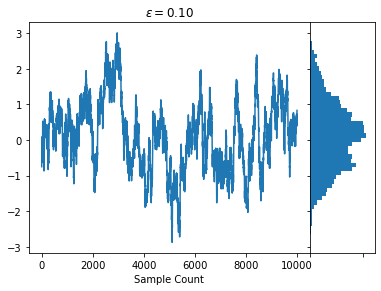

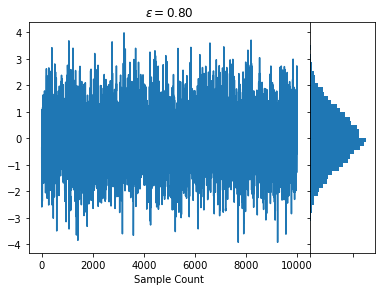

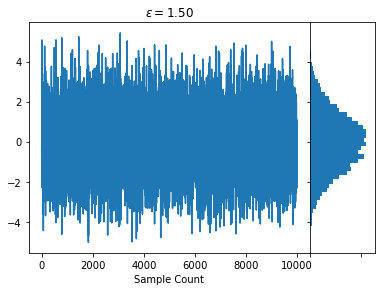

In [129]:
# Parameters
ep_list = np.linspace(0.1, 5, 8)


for epsilon in ep_list:
    
    # Number of samples
    N = 10000

    # Initialize samples
    samples = np.zeros(N)

    # First sample
    samples[0] = np.random.randn()

    for n in range(1, N):
        u = np.random.normal(0, 1)
        samples[n] = samples[n-1] * (1 - 0.5 * np.power(epsilon, 2)) + epsilon * u
    
    # plot trace
    if np.inf in samples:
        print(f"Warning!! Episilon: {epsilon:.2f}, Samples contain infinity value. Can't plot!!")
        continue
    traceplots(samples.reshape(-1, 1), title=f"$\epsilon={epsilon:.2f}$")

This approach starts to break for $\epsilon > 2$.


Let's continue with $\epsilon = 1.5$,

The markov process converges to a normal distribution with mean: -0.000 and variance: 2.292


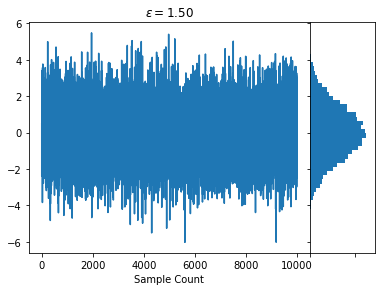

In [130]:
# Number of samples
N = 10000

# Hyperparameter
epsilon = 1.5

# Initialize samples
samples = np.zeros(N)

# First sample
samples[0] = np.random.randn()

for n in range(1, N):
    u = np.random.normal(0, 1)
    samples[n] = samples[n-1] * (1 - 0.5 * np.power(epsilon, 2)) + epsilon * u

# Traceplot
traceplots(samples.reshape(-1, 1), title=f"$\epsilon={epsilon:.2f}$")

# Mean and variance of the samples
mean_1, std_1 = samples.mean(), samples.std()

print(f"The markov process converges to a normal distribution with mean: {mean_1:.3f} and variance: {std_1**2:.3f}")

### Solution (b)

In order to convert the morkov process shown above into an MCMC scheme, we will introduce an Metropolis-Hastings accept-reject mechanism where the acceptance probability $\alpha$ is given as,

$$\alpha = min\bigg\{1, \frac{p(\theta_p)q(\theta_c|\theta_p)}{p(\theta_c)q(\theta_p|\theta_c)} \bigg\}$$

where $\theta_p$ is the proposed sample, $\theta_c$ is the last accepted sample. The proposals are generated as, 

$$\bar\theta_c = \theta_c + \frac{\epsilon^2}{2} \left. \nabla_\theta \log p(\theta) \right|_{\theta=\theta_c}$$

$$\theta_p \sim \mathcal{N}(\bar\theta_c, \epsilon^2)$$

Since the proposals here include a gradient term, the proposal distribution is not symmetric. Hence, the jump probabilities do not cancel out and we have to consider the q densities

In [131]:
class MCMC:

    def generate_sample(self, theta_c):
        raise("Implement in the subclass!")
    
    def run_sampling(self, N=1000):
        # Initialize samples
        samples = np.zeros(N)

        # First sample
        samples[0] = np.random.randn()

        # Count of accepted samples
        N_accepted = 0

        # Start sampling
        for n in range(N-1):
            
            # Generate proposal
            theta_c = samples[n]
            samples[n + 1], accepted = self.generate_sample(theta_c)

            if accepted:
                N_accepted += 1
        
        print(f"Acceptance ratio: {N_accepted/N:.2f}")
        
        return samples, accepted

    def plot_samples(self, samples):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.grid(alpha = 0.2)
        ax.hist(samples, bins=50, alpha=0.6, density=True)
        ax.set_title("Sampled Distribution")
        return ax



In [132]:
class MALA(MCMC):
    def __init__(self, epsilon=2):
        self.epsilon = epsilon

    def logq(self, theta, theta_bar, epsilon):
        return stats.norm(theta_bar, epsilon).logpdf(theta)
    
    def logp(self, theta):
        return -0.5 * np.log(2 * np.pi) - 0.5 * theta**2
    
    def generate_sample(self, theta_c):
        
        n = np.random.normal(0, 1)
        theta_c_bar = theta_c * (1 - 0.5 * np.power(self.epsilon, 2)) 

        theta_p = theta_c_bar + self.epsilon * n
        theta_p_bar = theta_p * (1 - 0.5 * np.power(self.epsilon, 2)) 

        # Evaluate acceptance prob
        delta_logp = self.logp(theta_p) - self.logp(theta_c)
        
        delta_logq = self.logq(theta_c, theta_p_bar, self.epsilon) - self.logq(theta_p, theta_c_bar, self.epsilon)

        alpha = min(1, np.exp(delta_logp + delta_logq))
        
        u = np.random.uniform(0, 1)

        # Accept/Reject
        if alpha > u:
            return theta_p, True
        else:
            return theta_c, False

Acceptance ratio: 0.74


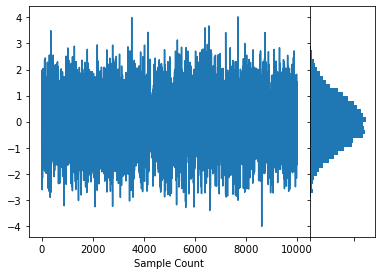

In [133]:
epsilon = 1.5
N = 10000
mala = MALA(epsilon=epsilon)
mala_samples, mala_accepted = mala.run_sampling(N)
traceplots(mala_samples.reshape(-1, 1))

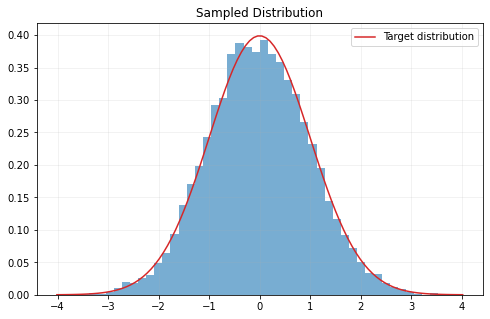

In [134]:
# Plot histogram
ax = mala.plot_samples(mala_samples)

x = np.linspace(mala_samples.min(), mala_samples.max(), 100)
y = stats.norm(0, 1).pdf(x)

ax.plot(x, y, color='tab:red', label='Target distribution')
ax.legend()

tau = [0]


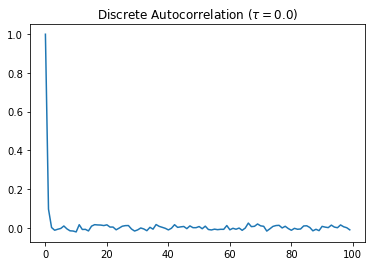

In [135]:
_ = autocorr(mala_samples.reshape(-1, 1), 100)

### MCMC - Random Walk

In [136]:
class RW(MCMC):

    def __init__(self, epsilon):
        self.epsilon = epsilon
    
    def logp(self, theta):
        return -0.5 * np.log(2 * np.pi) - 0.5 * theta**2
    
    def generate_sample(self, theta_c):
        
        theta_p = theta_c + self.epsilon * np.random.normal(0, 1)

        # Evaluate acceptance prob
        delta_logp = self.logp(theta_p) - self.logp(theta_c)

        alpha = min(1, np.exp(delta_logp))
        
        u = np.random.uniform(0, 1)

        # Accept/Reject
        if alpha > u:
            return theta_p, True
        else:
            return theta_c, False

In [137]:
rw_mcmc = RW(epsilon=epsilon)
rw_samples, accepted = rw_mcmc.run_sampling(N)

Acceptance ratio: 0.59


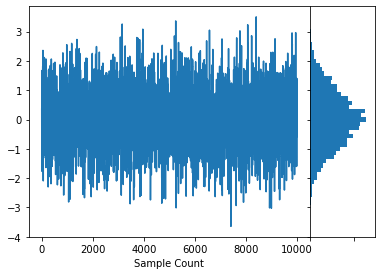

In [138]:
traceplots(rw_samples.reshape(-1, 1))

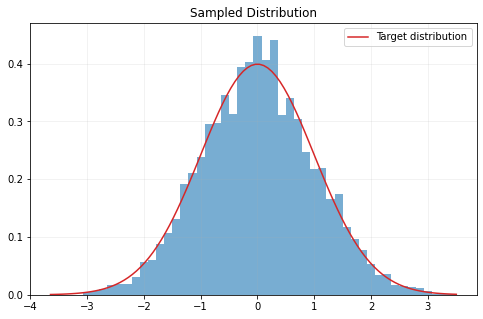

In [139]:
# Plot histogram
ax = rw_mcmc.plot_samples(rw_samples)

x = np.linspace(rw_samples.min(), rw_samples.max(), 100)
y = stats.norm(0, 1).pdf(x)

ax.plot(x, y, color='tab:red', label='Target distribution')
ax.legend()

In [140]:
# Stationary distribution of the Markov Chains
mean , std = mala_samples.mean(), mala_samples.std()
print(f"The MALA sampler converges to a normal distribution with mean: {mean:.3f} and variance: {std**2:.3f}")


mean , std = rw_samples.mean(), rw_samples.std()
print(f"The MCMC-RW sampler converges to a normal distribution with mean: {mean:.3f} and variance: {std**2:.3f}")

The MALA sampler converges to a normal distribution with mean: -0.017 and variance: 0.998
The MCMC-RW sampler converges to a normal distribution with mean: 0.019 and variance: 0.981


tau = [5]


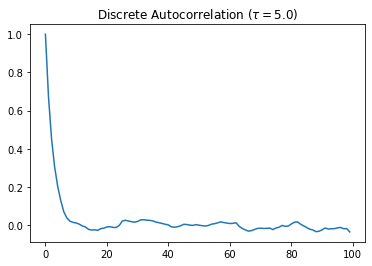

In [141]:
_ = autocorr(rw_samples.reshape(-1, 1), 100)

For the same value of $\epsilon$, the integrated autocorrelation time $\tau$ is lower for MALA Sampler ($\tau=2$) compared to the MCMC random walk ($\tau=5$). This implies that the random walk sampler holds the correlation approx. 2.5 times longer than the MALA scheme. The gradient-based proposals in MALA sampler lead to a faster convergence.